In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

def load_mnist():
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    X = mnist.data / 255.0
    y = mnist.target.astype(int)

    encoder = OneHotEncoder(sparse_output=False, categories='auto')
    y_onehot = encoder.fit_transform(y.reshape(-1, 1))

    return train_test_split(X, y_onehot, test_size=0.2, random_state=42)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mse_loss_derivative(y_true, y_pred):
    return (y_pred - y_true) / y_true.shape[0]

def train_nn(X_train, y_train, input_size=784, hidden_size=64, output_size=10, epochs=10, lr=0.1):
    W1 = np.random.randn(input_size, hidden_size) * 0.01
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, output_size) * 0.01
    b2 = np.zeros((1, output_size))

    for epoch in range(epochs):
        total_loss = 0

        for i in range(X_train.shape[0]):
            x = X_train[i:i+1]
            y = y_train[i:i+1]

            z1 = np.dot(x, W1) + b1
            a1 = sigmoid(z1)
            z2 = np.dot(a1, W2) + b2
            a2 = sigmoid(z2)

            loss = mse_loss(y, a2)
            total_loss += loss

            dz2 = mse_loss_derivative(y, a2) * sigmoid_derivative(z2)
            dW2 = np.dot(a1.T, dz2)
            db2 = dz2

            dz1 = np.dot(dz2, W2.T) * sigmoid_derivative(z1)
            dW1 = np.dot(x.T, dz1)
            db1 = dz1

            W2 -= lr * dW2
            b2 -= lr * db2
            W1 -= lr * dW1
            b1 -= lr * db1

        print(f"Epoch {epoch+1}, Loss: {total_loss / X_train.shape[0]:.4f}")

    return W1, b1, W2, b2

X_train, X_test, y_train, y_test = load_mnist()
W1, b1, W2, b2 = train_nn(X_train, y_train, epochs=5)

def test_nn(X_test, y_test, W1, b1, W2, b2):
    z1 = np.dot(X_test, W1) + b1
    a1 = sigmoid(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = sigmoid(z2)

    predictions = np.argmax(a2, axis=1)
    true_labels = np.argmax(y_test, axis=1)

    accuracy = np.mean(predictions == true_labels)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

test_nn(X_test, y_test, W1, b1, W2, b2)


Epoch 1, Loss: 0.0216
Epoch 2, Loss: 0.0096
Epoch 3, Loss: 0.0075
Epoch 4, Loss: 0.0064
Epoch 5, Loss: 0.0056
Test Accuracy: 96.13%


Epoch [1/10], Loss: 0.0395
Epoch [2/10], Loss: 0.0169
Epoch [3/10], Loss: 0.0116
Epoch [4/10], Loss: 0.0091
Epoch [5/10], Loss: 0.0075
Epoch [6/10], Loss: 0.0060
Epoch [7/10], Loss: 0.0046
Epoch [8/10], Loss: 0.0037
Epoch [9/10], Loss: 0.0032
Epoch [10/10], Loss: 0.0028


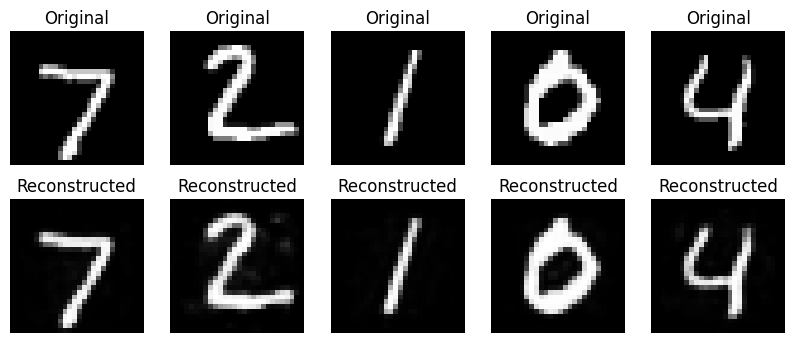

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

model.eval()
with torch.no_grad():
    data_iter = iter(test_loader)

    images, _ = next(data_iter)
    images = images.to(device)

    reconstructed = model(images)

    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(5):
        axes[0, i].imshow(images[i].cpu().view(28, 28), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        axes[1, i].imshow(reconstructed[i].cpu().view(28, 28), cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')

    plt.show()


In [ ]:
#########accuracy calculation of above autoencoder
def calculate_accuracy(images, reconstructed):
    # Since images are in the range [0, 1], we threshold them to binary values
    images_bin = (images > 0.5).float()
    reconstructed_bin = (reconstructed > 0.5).float()
    
    correct_pixels = (images_bin == reconstructed_bin).float().sum()
    total_pixels = images_bin.numel()
    
    accuracy = (correct_pixels / total_pixels) * 100
    return accuracy

accuracy = calculate_accuracy(images, reconstructed)
print(f"Pixel-wise Accuracy: {accuracy:.2f}%")

Pixel-wise Accuracy: 98.69%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(28*28, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 10)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.sigmoid(self.layer1(x))
        x = self.sigmoid(self.layer2(x))
        x = self.sigmoid(self.layer3(x))
        return x

model = MLP().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

def one_hot_encode(labels, num_classes=10):
    return torch.eye(num_classes, device=labels.device)[labels]

num_epochs = 5
for epoch in range(num_epochs):
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        targets = one_hot_encode(labels)

        outputs = model(images)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    return accuracy

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Epoch [1/5], Loss: 0.0954
Epoch [2/5], Loss: 0.0899
Epoch [3/5], Loss: 0.0899
Epoch [4/5], Loss: 0.0898
Epoch [5/5], Loss: 0.0898
Test Accuracy: 12.82%


Pretraining Autoencoders...
AE1 Epoch [1/10], Loss: 0.0818
AE1 Epoch [2/10], Loss: 0.0678
AE1 Epoch [3/10], Loss: 0.0666
AE1 Epoch [4/10], Loss: 0.0650
AE1 Epoch [5/10], Loss: 0.0627
AE1 Epoch [6/10], Loss: 0.0600
AE1 Epoch [7/10], Loss: 0.0571
AE1 Epoch [8/10], Loss: 0.0545
AE1 Epoch [9/10], Loss: 0.0521
AE1 Epoch [10/10], Loss: 0.0500
AE2 Epoch [1/10], Loss: 0.0355
AE2 Epoch [2/10], Loss: 0.0306
AE2 Epoch [3/10], Loss: 0.0230
AE2 Epoch [4/10], Loss: 0.0165
AE2 Epoch [5/10], Loss: 0.0130
AE2 Epoch [6/10], Loss: 0.0109
AE2 Epoch [7/10], Loss: 0.0095
AE2 Epoch [8/10], Loss: 0.0085
AE2 Epoch [9/10], Loss: 0.0077
AE2 Epoch [10/10], Loss: 0.0070

Training plain MLP...
Epoch [1/20], Train Loss: 0.0913, Val Loss: 0.0898, Train Acc: 0.1149, Val Acc: 0.1171
Epoch [2/20], Train Loss: 0.0897, Val Loss: 0.0895, Train Acc: 0.1328, Val Acc: 0.1171
Epoch [3/20], Train Loss: 0.0892, Val Loss: 0.0886, Train Acc: 0.1868, Val Acc: 0.2804
Epoch [4/20], Train Loss: 0.0862, Val Loss: 0.0802, Train Acc: 0.2

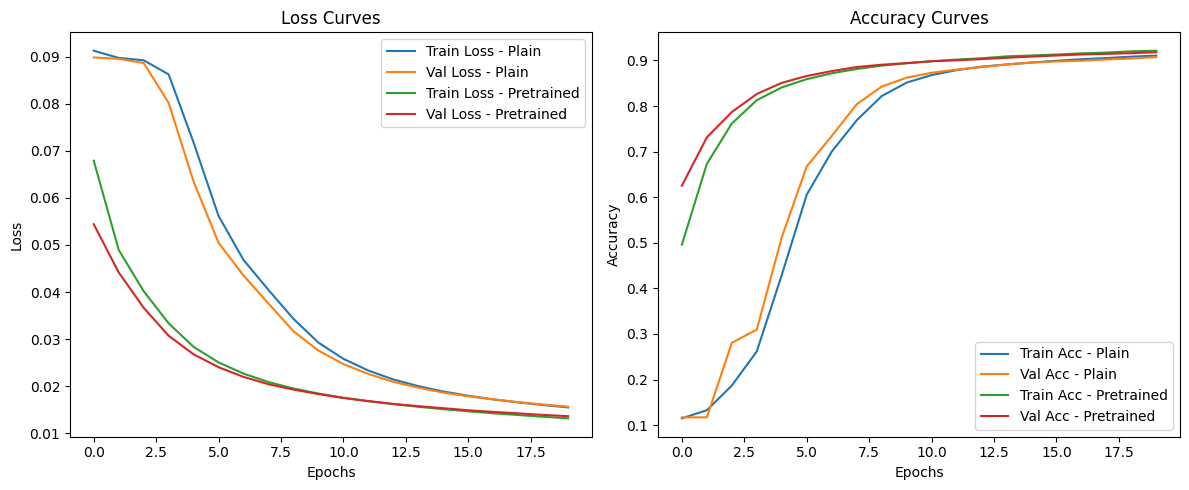

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
input_size = 784
hidden1_size = 256
hidden2_size = 128
output_size = 10
batch_size = 64
pretrain_epochs = 10
finetune_epochs = 20
learning_rate = 0.1
momentum = 0.9

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_data, val_data = random_split(train_dataset, [50000, 10000])
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Sigmoid()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Pretrain autoencoders
print("Pretraining Autoencoders...")
autoencoder1 = Autoencoder(input_size, hidden1_size).to(device)
optimizer1 = optim.SGD(autoencoder1.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.MSELoss()

for epoch in range(pretrain_epochs):
    total_loss = 0
    for batch, _ in train_loader:
        batch = batch.to(device)
        optimizer1.zero_grad()
        loss = criterion(autoencoder1(batch), batch)
        loss.backward()
        optimizer1.step()
        total_loss += loss.item()
    print(f"AE1 Epoch [{epoch+1}/{pretrain_epochs}], Loss: {total_loss/len(train_loader):.4f}")

# Get encoded data from autoencoder1
autoencoder2 = Autoencoder(hidden1_size, hidden2_size).to(device)
optimizer2 = optim.SGD(autoencoder2.parameters(), lr=learning_rate, momentum=momentum)

for epoch in range(pretrain_epochs):
    total_loss = 0
    for batch, _ in train_loader:
        batch = batch.to(device)
        with torch.no_grad():
            encoded1 = autoencoder1.encoder(batch)
        optimizer2.zero_grad()
        loss = criterion(autoencoder2(encoded1), encoded1)
        loss.backward()
        optimizer2.step()
        total_loss += loss.item()
    print(f"AE2 Epoch [{epoch+1}/{pretrain_epochs}], Loss: {total_loss/len(train_loader):.4f}")

# Define MLP model
class MLP(nn.Module):
    def __init__(self, pretrained=False):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, output_size)
        self.sigmoid = nn.Sigmoid()
        if pretrained:
            self.fc1.weight.data = autoencoder1.encoder[0].weight.data.clone()
            self.fc1.bias.data = autoencoder1.encoder[0].bias.data.clone()
            self.fc2.weight.data = autoencoder2.encoder[0].weight.data.clone()
            self.fc2.bias.data = autoencoder2.encoder[0].bias.data.clone()

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Training function
def train(model, train_loader, val_loader, epochs):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0
        for batch, labels in train_loader:
            batch, labels = batch.to(device), labels.to(device)
            targets = torch.zeros(batch.size(0), output_size).to(device)
            targets[range(batch.size(0)), labels] = 1

            optimizer.zero_grad()
            outputs = model(batch)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pred = outputs.argmax(dim=1)
            correct += (pred == labels).sum().item()

        train_loss = total_loss / len(train_loader)
        train_acc = correct / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        total_loss, correct = 0, 0
        with torch.no_grad():
            for batch, labels in val_loader:
                batch, labels = batch.to(device), labels.to(device)
                targets = torch.zeros(batch.size(0), output_size).to(device)
                targets[range(batch.size(0)), labels] = 1
                outputs = model(batch)
                loss = criterion(outputs, targets)
                total_loss += loss.item()
                pred = outputs.argmax(dim=1)
                correct += (pred == labels).sum().item()

        val_loss = total_loss / len(val_loader)
        val_acc = correct / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    return train_losses, val_losses, train_accs, val_accs

# Train plain MLP
print("\nTraining plain MLP...")
plain_mlp = MLP(pretrained=False)
plain_results = train(plain_mlp, train_loader, val_loader, finetune_epochs)

# Train pretrained MLP
print("\nTraining pretrained MLP...")
pretrained_mlp = MLP(pretrained=True)
pretrained_results = train(pretrained_mlp, train_loader, val_loader, finetune_epochs)

# Plotting results
train_loss_plain, val_loss_plain, train_acc_plain, val_acc_plain = plain_results
train_loss_pre, val_loss_pre, train_acc_pre, val_acc_pre = pretrained_results

epochs = range(finetune_epochs)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_plain, label='Train Loss - Plain')
plt.plot(epochs, val_loss_plain, label='Val Loss - Plain')
plt.plot(epochs, train_loss_pre, label='Train Loss - Pretrained')
plt.plot(epochs, val_loss_pre, label='Val Loss - Pretrained')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_plain, label='Train Acc - Plain')
plt.plot(epochs, val_acc_plain, label='Val Acc - Plain')
plt.plot(epochs, train_acc_pre, label='Train Acc - Pretrained')
plt.plot(epochs, val_acc_pre, label='Val Acc - Pretrained')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.tight_layout()
plt.show()


Epoch 1/20 - Train Loss: 0.2608, Val Loss: 0.0980, Val Acc: 0.9720
Epoch 2/20 - Train Loss: 0.0754, Val Loss: 0.0892, Val Acc: 0.9737
Epoch 3/20 - Train Loss: 0.0528, Val Loss: 0.0572, Val Acc: 0.9830
Epoch 4/20 - Train Loss: 0.0400, Val Loss: 0.0538, Val Acc: 0.9835
Epoch 5/20 - Train Loss: 0.0362, Val Loss: 0.0505, Val Acc: 0.9845
Epoch 6/20 - Train Loss: 0.0279, Val Loss: 0.0576, Val Acc: 0.9825
Epoch 7/20 - Train Loss: 0.0250, Val Loss: 0.0443, Val Acc: 0.9860
Epoch 8/20 - Train Loss: 0.0211, Val Loss: 0.0564, Val Acc: 0.9825
Epoch 9/20 - Train Loss: 0.0186, Val Loss: 0.0445, Val Acc: 0.9867
Epoch 10/20 - Train Loss: 0.0159, Val Loss: 0.0458, Val Acc: 0.9863
Epoch 11/20 - Train Loss: 0.0128, Val Loss: 0.0435, Val Acc: 0.9878
Epoch 12/20 - Train Loss: 0.0133, Val Loss: 0.0386, Val Acc: 0.9883
Epoch 13/20 - Train Loss: 0.0120, Val Loss: 0.0444, Val Acc: 0.9888
Epoch 14/20 - Train Loss: 0.0093, Val Loss: 0.0435, Val Acc: 0.9885
Epoch 15/20 - Train Loss: 0.0092, Val Loss: 0.0444, Val A

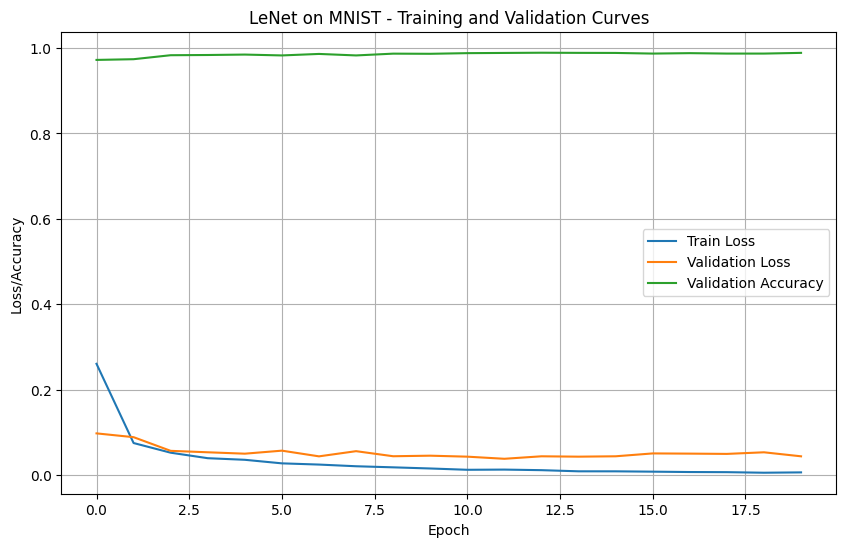

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)

# Define LeNet Architecture
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.tanh(self.conv1(x)))
        x = self.pool(F.tanh(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

# Load MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_val_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)

# Initialize Model, Optimizer, and Loss
model = LeNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training
epochs = 20
train_losses, val_losses, val_accuracies = [], [], []
best_val_loss = float('inf')
best_val_acc = 0.0
best_loss_model = None
best_acc_model = None

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            val_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Save best models
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_loss_model = model.state_dict()
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        best_acc_model = model.state_dict()

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.title('LeNet on MNIST - Training and Validation Curves')
plt.grid(True)
plt.show()


Using device: cuda

Experimenting with learning rate: 0.01
Epoch 1/5
----------
Iteration 1, Train Loss: 2.2543, Val Loss: 2.0668, Val Accuracy: 0.4201
Iteration 2, Train Loss: 1.1208, Val Loss: 0.5795, Val Accuracy: 0.8118
Iteration 3, Train Loss: 0.4003, Val Loss: 0.2895, Val Accuracy: 0.9107
Iteration 4, Train Loss: 0.2743, Val Loss: 0.2226, Val Accuracy: 0.9356
Iteration 5, Train Loss: 0.2172, Val Loss: 0.1667, Val Accuracy: 0.9483
Iteration 6, Train Loss: 0.1791, Val Loss: 0.1459, Val Accuracy: 0.9561
Iteration 7, Train Loss: 0.1618, Val Loss: 0.1263, Val Accuracy: 0.9622
Iteration 8, Train Loss: 0.1203, Val Loss: 0.1468, Val Accuracy: 0.9543
Iteration 9, Train Loss: 0.1205, Val Loss: 0.1349, Val Accuracy: 0.9576
Iteration 10, Train Loss: 0.1201, Val Loss: 0.1032, Val Accuracy: 0.9680
Iteration 11, Train Loss: 0.1009, Val Loss: 0.1092, Val Accuracy: 0.9661
Iteration 12, Train Loss: 0.1226, Val Loss: 0.1155, Val Accuracy: 0.9640
Iteration 13, Train Loss: 0.0966, Val Loss: 0.1078, V

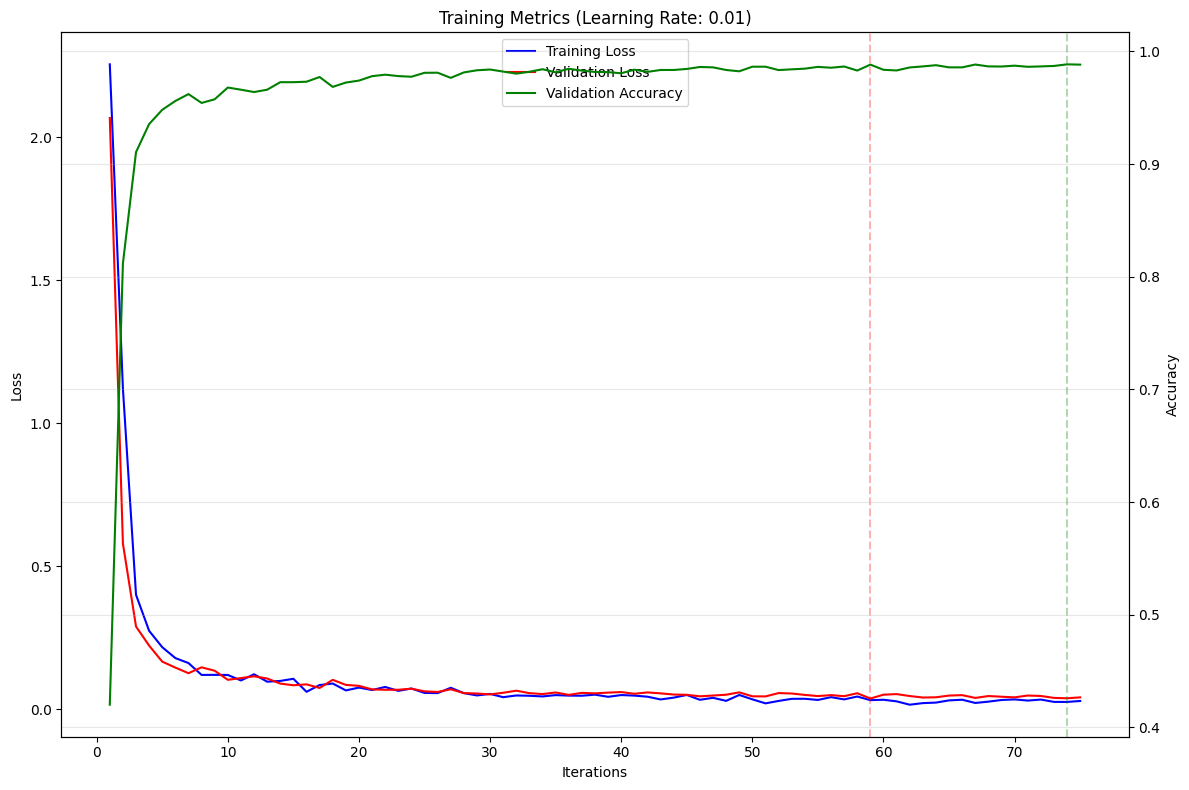

Test Accuracy: 99.08%
Test Accuracy: 98.96%
Results for learning rate 0.01:
Best validation loss: 0.0378 at iteration 59
Best validation accuracy: 0.9886 at iteration 74
Test accuracy using best loss model: 99.08%
Test accuracy using best acc model: 98.96%

Experimenting with learning rate: 0.001
Epoch 1/5
----------
Iteration 1, Train Loss: 2.2997, Val Loss: 2.2987, Val Accuracy: 0.1253
Iteration 2, Train Loss: 2.2937, Val Loss: 2.2880, Val Accuracy: 0.1857
Iteration 3, Train Loss: 2.2789, Val Loss: 2.2733, Val Accuracy: 0.2516
Iteration 4, Train Loss: 2.2621, Val Loss: 2.2487, Val Accuracy: 0.4078
Iteration 5, Train Loss: 2.2268, Val Loss: 2.1998, Val Accuracy: 0.5077
Iteration 6, Train Loss: 2.1470, Val Loss: 2.0769, Val Accuracy: 0.5211
Iteration 7, Train Loss: 1.9200, Val Loss: 1.6926, Val Accuracy: 0.6014
Iteration 8, Train Loss: 1.3368, Val Loss: 0.9885, Val Accuracy: 0.7215
Iteration 9, Train Loss: 0.7940, Val Loss: 0.6662, Val Accuracy: 0.7917
Iteration 10, Train Loss: 0.6003,

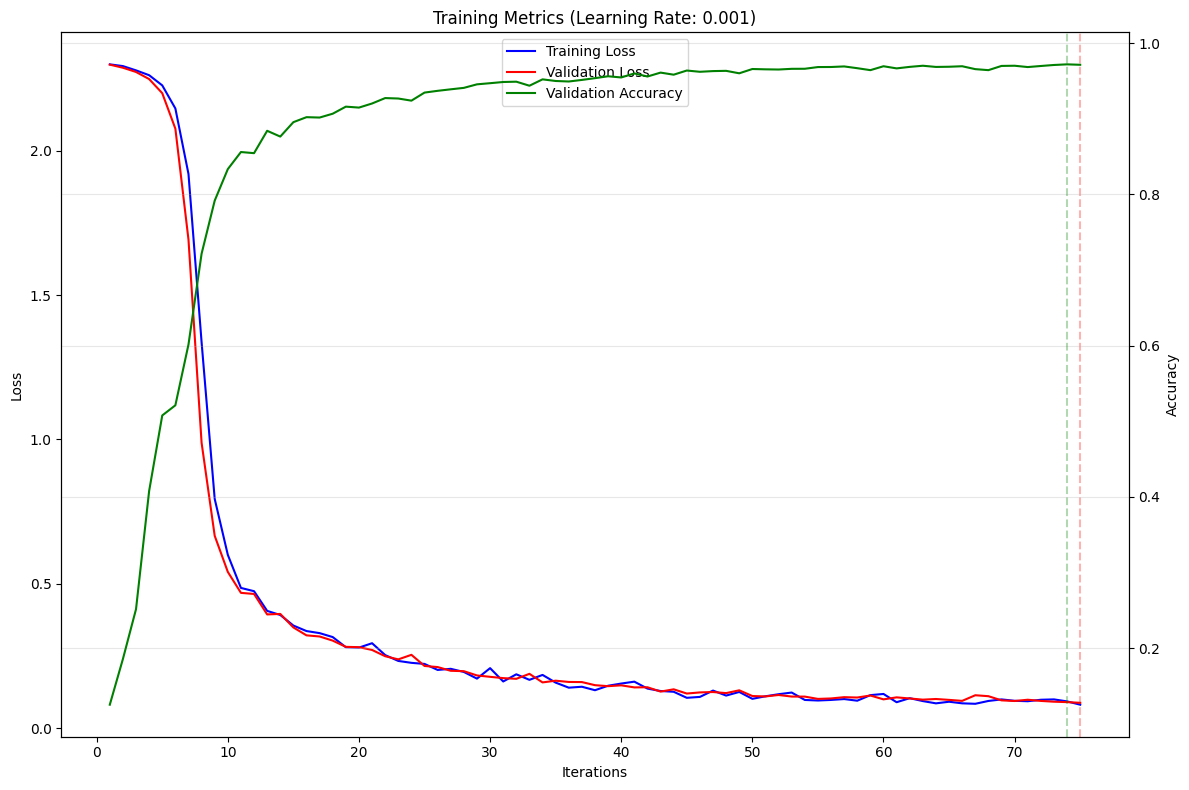

Test Accuracy: 97.72%
Test Accuracy: 97.67%
Results for learning rate 0.001:
Best validation loss: 0.0876 at iteration 75
Best validation accuracy: 0.9718 at iteration 74
Test accuracy using best loss model: 97.72%
Test accuracy using best acc model: 97.67%

Experimenting with learning rate: 0.0001
Epoch 1/5
----------
Iteration 1, Train Loss: 2.3028, Val Loss: 2.3007, Val Accuracy: 0.1093
Iteration 2, Train Loss: 2.3016, Val Loss: 2.2995, Val Accuracy: 0.1168
Iteration 3, Train Loss: 2.2989, Val Loss: 2.2981, Val Accuracy: 0.1294
Iteration 4, Train Loss: 2.2974, Val Loss: 2.2968, Val Accuracy: 0.1408
Iteration 5, Train Loss: 2.2956, Val Loss: 2.2955, Val Accuracy: 0.1527
Iteration 6, Train Loss: 2.2933, Val Loss: 2.2943, Val Accuracy: 0.1604
Iteration 7, Train Loss: 2.2947, Val Loss: 2.2930, Val Accuracy: 0.1693
Iteration 8, Train Loss: 2.2921, Val Loss: 2.2916, Val Accuracy: 0.1762
Iteration 9, Train Loss: 2.2922, Val Loss: 2.2901, Val Accuracy: 0.1827
Iteration 10, Train Loss: 2.289

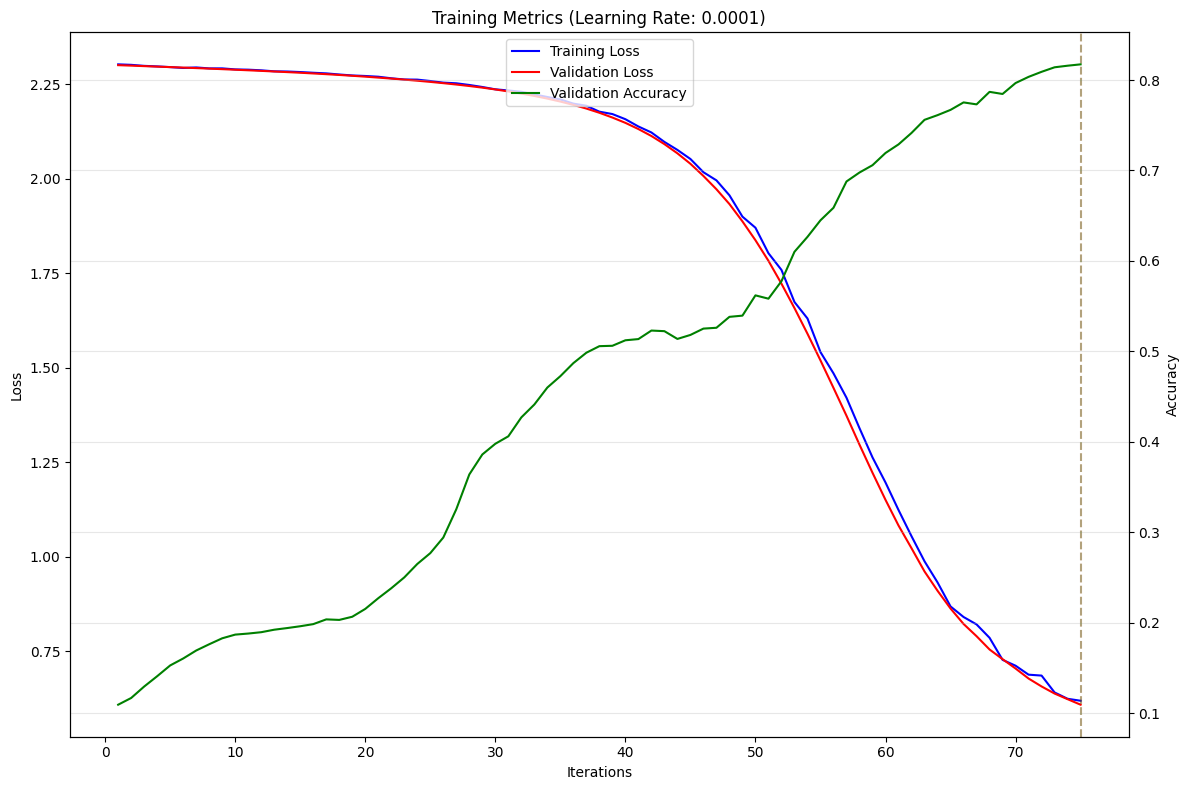

Test Accuracy: 83.21%
Test Accuracy: 83.21%
Results for learning rate 0.0001:
Best validation loss: 0.6087 at iteration 75
Best validation accuracy: 0.8173 at iteration 75
Test accuracy using best loss model: 83.21%
Test accuracy using best acc model: 83.21%

Summary of results:

Learning rate: 0.01
Best validation loss: 0.0378 at iteration 59
Best validation accuracy: 0.9886 at iteration 74
Test accuracy from best loss model: 99.08%
Test accuracy from best acc model: 98.96%
Note: Best loss and best accuracy occur at different iterations
The model selected by validation loss performs better on test data

Learning rate: 0.001
Best validation loss: 0.0876 at iteration 75
Best validation accuracy: 0.9718 at iteration 74
Test accuracy from best loss model: 97.72%
Test accuracy from best acc model: 97.67%
Note: Best loss and best accuracy occur at different iterations
The model selected by validation loss performs better on test data

Learning rate: 0.0001
Best validation loss: 0.6087 at it

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import time
import copy

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def get_data_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=True,
        transform=transform,
        download=True
    )

    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        train_dataset, [train_size, val_size])

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True
    )

    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    test_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=False,
        transform=transform
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    return train_loader, val_loader, test_loader

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.to(device)

    train_losses = []
    val_losses = []
    val_accuracies = []
    iterations = []

    best_val_loss = float('inf')
    best_val_acc = 0.0
    best_model_wts_loss = None
    best_model_wts_acc = None

    best_epoch_loss = 0
    best_epoch_acc = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 10)

        model.train()
        running_loss = 0.0
        iteration = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (batch_idx + 1) % 50 == 0:
                iteration = epoch * len(train_loader) // 50 + (batch_idx + 1) // 50
                iterations.append(iteration)

                avg_train_loss = running_loss / 50
                train_losses.append(avg_train_loss)
                running_loss = 0.0

                model.eval()
                val_loss = 0.0
                correct = 0
                total = 0

                with torch.no_grad():
                    for val_images, val_labels in val_loader:
                        val_images = val_images.to(device)
                        val_labels = val_labels.to(device)

                        val_outputs = model(val_images)
                        val_batch_loss = criterion(val_outputs, val_labels)

                        val_loss += val_batch_loss.item()

                        _, predicted = torch.max(val_outputs.data, 1)
                        total += val_labels.size(0)
                        correct += (predicted == val_labels).sum().item()

                val_loss = val_loss / len(val_loader)
                val_accuracy = correct / total

                val_losses.append(val_loss)
                val_accuracies.append(val_accuracy)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_wts_loss = copy.deepcopy(model.state_dict())
                    best_epoch_loss = iteration

                if val_accuracy > best_val_acc:
                    best_val_acc = val_accuracy
                    best_model_wts_acc = copy.deepcopy(model.state_dict())
                    best_epoch_acc = iteration

                print(f"Iteration {iteration}, Train Loss: {avg_train_loss:.4f}, "
                      f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

                model.train()

    assert len(iterations) == len(train_losses) == len(val_losses) == len(val_accuracies)

    return {
        'iterations': iterations,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'best_model_wts_loss': best_model_wts_loss,
        'best_model_wts_acc': best_model_wts_acc,
        'best_epoch_loss': best_epoch_loss,
        'best_epoch_acc': best_epoch_acc,
        'best_val_loss': best_val_loss,
        'best_val_acc': best_val_acc
    }

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

def plot_metrics(iterations, train_losses, val_losses, val_accuracies,
                best_epoch_loss, best_epoch_acc, learning_rate):
    plt.figure(figsize=(12, 8))

    ax1 = plt.gca()
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    line1, = ax1.plot(iterations, train_losses, 'b-', label='Training Loss')
    line2, = ax1.plot(iterations, val_losses, 'r-', label='Validation Loss')

    ax1.axvline(x=best_epoch_loss, color='r', linestyle='--', alpha=0.3,
               label=f'Best Val Loss at iter {best_epoch_loss}')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy')

    line3, = ax2.plot(iterations, val_accuracies, 'g-', label='Validation Accuracy')

    ax2.axvline(x=best_epoch_acc, color='g', linestyle='--', alpha=0.3,
               label=f'Best Val Acc at iter {best_epoch_acc}')

    lines = [line1, line2, line3]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper center')

    plt.title(f'Training Metrics (Learning Rate: {learning_rate})')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'lenet_training_lr_{learning_rate}.png')
    plt.show()

def experiment_with_learning_rates(learning_rates=[0.01, 0.001, 0.0001], batch_size=64, num_epochs=5):
    results = {}

    for lr in learning_rates:
        print(f"\nExperimenting with learning rate: {lr}")

        train_loader, val_loader, test_loader = get_data_loaders(batch_size)

        model = LeNet()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

        history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

        plot_metrics(
            history['iterations'],
            history['train_losses'],
            history['val_losses'],
            history['val_accuracies'],
            history['best_epoch_loss'],
            history['best_epoch_acc'],
            lr
        )

        model.load_state_dict(history['best_model_wts_loss'])
        loss_based_accuracy = evaluate_model(model, test_loader)

        model.load_state_dict(history['best_model_wts_acc'])
        acc_based_accuracy = evaluate_model(model, test_loader)

        results[lr] = {
            'best_val_loss': history['best_val_loss'],
            'best_val_acc': history['best_val_acc'],
            'best_epoch_loss': history['best_epoch_loss'],
            'best_epoch_acc': history['best_epoch_acc'],
            'test_acc_from_best_loss_model': loss_based_accuracy,
            'test_acc_from_best_acc_model': acc_based_accuracy
        }

        print(f"Results for learning rate {lr}:")
        print(f"Best validation loss: {history['best_val_loss']:.4f} at iteration {history['best_epoch_loss']}")
        print(f"Best validation accuracy: {history['best_val_acc']:.4f} at iteration {history['best_epoch_acc']}")
        print(f"Test accuracy using best loss model: {loss_based_accuracy:.2f}%")
        print(f"Test accuracy using best acc model: {acc_based_accuracy:.2f}%")

    return results

if __name__ == "__main__":
    learning_rates = [0.01, 0.001, 0.0001]
    results = experiment_with_learning_rates(learning_rates, batch_size=64, num_epochs=5)

    print("\nSummary of results:")
    for lr, metrics in results.items():
        print(f"\nLearning rate: {lr}")
        print(f"Best validation loss: {metrics['best_val_loss']:.4f} at iteration {metrics['best_epoch_loss']}")
        print(f"Best validation accuracy: {metrics['best_val_acc']:.4f} at iteration {metrics['best_epoch_acc']}")
        print(f"Test accuracy from best loss model: {metrics['test_acc_from_best_loss_model']:.2f}%")
        print(f"Test accuracy from best acc model: {metrics['test_acc_from_best_acc_model']:.2f}%")

        if metrics['best_epoch_loss'] != metrics['best_epoch_acc']:
            print(f"Note: Best loss and best accuracy occur at different iterations")
            if metrics['test_acc_from_best_loss_model'] > metrics['test_acc_from_best_acc_model']:
                print("The model selected by validation loss performs better on test data")
            else:
                print("The model selected by validation accuracy performs better on test data")